# Model v0
- Kaggle public leaderboard score: 0.38679
- Kaggle public leaderboard position: 1196

In [1]:
from keras.layers import Input, LSTM, Dense, Dropout, Embedding, TimeDistributed, Reshape
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate

In [3]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [4]:
import tensorflow as tf
from keras import backend as K

In [5]:
from sklearn import preprocessing

In [6]:
from sklearn_pandas import DataFrameMapper

In [7]:
import pandas as pd
import numpy as np

In [8]:
from keras.utils.np_utils import to_categorical

In [9]:
LABEL = "price_doc"

In [10]:
def prepare_dataset(df, test=False, trunc_fields=False):
    global LABEL
    t_fields = ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor','material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', LABEL]
    
    if not test:
        if trunc_fields:
            df = df[t_fields.append + LABEL]
        else:
            df = df
    else:
        if trunc_fields:
            df = df[t_fields]
        else:
            df = df
    
    df['timestamp_converted'] = pd.to_datetime(df['timestamp'])
    df['timestamp_day'] = df.apply(lambda row: row['timestamp_converted'].day, axis=1)
    df['timestamp_month'] = df.apply(lambda row: row['timestamp_converted'].month, axis=1)
    df['timestamp_year'] = df.apply(lambda row: row['timestamp_converted'].year, axis=1)
    df['state_refractored'] = df.apply( lambda row: 5 if row['state'] == 33 else row['state'] , axis = 1)
    
    df = df.fillna(0)
    
    df['state_refractored'] = df['state_refractored'].astype(int)    
    df['material'] = df['material'].astype(int)    
    return df

In [11]:
final_train_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/final_training_dataset.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (375,378,379) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
final_train_df = prepare_dataset(final_train_df)

In [13]:
del final_train_df['Unnamed: 0']

In [14]:
final_train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


## Data prep

In [15]:
columns = [
 'full_sq',
'kitch_sq',
 'floor',
 'life_sq',
 'build_year',
 'railroad_km',
 'metro_min_avto',
 'green_zone_km',
 'kindergarten_km',
 'num_room',
 'material',
 'public_transport_station_km',
 'metro_km_avto',
 'max_floor',
 'micex',
 'usdrub',
 'sub_area',
 'state_refractored',
 'park_km',
 'micex_cbi_tr',
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
 'cemetery_km',
 'mosque_km',
 'public_healthcare_km',
 'catering_km',
 'big_road2_km',
 'hospice_morgue_km',
 'swim_pool_km',
 'water_treatment_km',
 'power_transmission_line_km',
 'water_km',
 'school_km',
 'ttk_km',
 'area_m',
 'university_km',
 'oil_chemistry_km',
 'exhibition_km',
 'shopping_centers_km',
 'ts_km',
 'zd_vokzaly_avto_km',
 'railroad_station_avto_min',
 'brent',
 'preschool_km',
 'big_road1_km',
 'additional_education_km',
 'green_part_1000',
 'church_synagogue_km',
 'big_church_km',
 'green_part_1500',
 'incineration_km',
 'industrial_km',
 'nuclear_reactor_km',
]

one_hot_cols = [
    'material',
    'state_refractored'
]

label_cols = [
    'sub_area',
]

exclude_normalize_columns = [
    # Specific columns to exclude...
] + one_hot_cols + label_cols

normalize_columns = [c for c in columns if c not in exclude_normalize_columns]

locality_columns = [c for c in columns if "_km" in c]
continuous_columns = [c for c in columns if c not in one_hot_cols and c not in label_cols]
continuous_columns_without_locality = [c for c in continuous_columns if c not in locality_columns]

In [16]:
final_train_df = final_train_df[columns + [LABEL]]

In [17]:
final_train_df.head()

,full_sq,kitch_sq,floor,life_sq,build_year,railroad_km,metro_min_avto,green_zone_km,kindergarten_km,num_room,...,big_road1_km,additional_education_km,green_part_1000,church_synagogue_km,big_church_km,green_part_1500,incineration_km,industrial_km,nuclear_reactor_km,price_doc
0,43,0.0,4.0,27.0,0.0,1.305159,2.590241,0.600973,0.145700,0.0,...,1.422391,0.947962,7.36,0.628187,0.625783,14.27,3.633334,1.080934,5.718519,5850000
1,34,0.0,3.0,19.0,0.0,0.694536,0.936700,0.065321,0.147754,0.0,...,2.887377,1.072315,26.66,0.471447,0.967821,21.53,8.648587,0.966479,3.489954,6000000
2,43,0.0,2.0,29.0,0.0,0.700691,2.120999,0.453172,0.049102,0.0,...,0.647250,0.391957,4.99,0.755946,3.178751,9.92,11.996480,0.939275,7.506612,5700000
3,89,0.0,9.0,50.0,0.0,1.999265,1.489049,0.106125,0.179441,0.0,...,2.677824,0.892674,19.25,1.561505,1.031777,28.38,14.317640,0.451173,9.522538,13100000
4,77,0.0,4.0,77.0,0.0,0.084113,1.257186,0.236214,0.247901,0.0,...,1.721834,0.810801,3.34,0.121681,0.378756,4.12,11.903910,0.392871,8.671016,16331452


In [18]:
final_train_df = final_train_df.convert_objects(convert_numeric=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


## Prepare numeric data scalers & normalizers

In [19]:
norm_scalers = {column : preprocessing.StandardScaler() for column in normalize_columns}

In [20]:
norm_scalers

{'additional_education_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'area_m': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_church_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road1_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road2_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'brent': StandardScaler(copy=True, with_mean=True, with_std=True),
 'build_year': StandardScaler(copy=True, with_mean=True, with_std=True),
 'catering_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'cemetery_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'church_synagogue_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'exhibition_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'floor': StandardScaler(copy=True, with_mean=True, with_std=True),
 'full_sq': StandardScaler(copy=True, with_mean=True, with_std=True),
 'green_part_1000': StandardScaler

In [21]:
ont_hot_scalers = {column : (preprocessing.LabelEncoder(), preprocessing.OneHotEncoder(sparse=False)) for column in one_hot_cols}

In [22]:
ont_hot_scalers

{'material': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False)),
 'state_refractored': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False))}

In [23]:
label_scalers = {column : preprocessing.LabelEncoder() for column in label_cols}

In [24]:
label_scalers

{'sub_area': LabelEncoder()}

In [25]:
for column in normalize_columns:
    c_scaler = norm_scalers[column]
    c_scaler.fit(final_train_df[[column]].values)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [26]:
for column in one_hot_cols:
    label_enc, one_hot_enc = ont_hot_scalers[column]
    r = label_enc.fit_transform(final_train_df[[column]].values)
    r = np.expand_dims(r, axis=1)
    one_hot_enc.fit(r)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [139]:
for column in label_cols:
    label_enc = label_scalers[column]
    label_enc.fit(final_train_df[[column]].values)

### Test the scalers...

In [28]:
norm_scalers['timestamp_day'].transform([final_train_df.ix[0]['timestamp_day']])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.40933319])

In [29]:
ont_hot_scalers['material'][1].transform([final_train_df.ix[70]['material']])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [30]:
label_scalers['sub_area'].transform([final_train_df.ix[0]['sub_area']])

array([9])

In [31]:
sub_area_metadata = open('/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv', 'w+')
sub_area_metadata.write("Sub area\n" + "\n".join([label_scalers['sub_area'].inverse_transform([i])[0] for i in range(146)]))
sub_area_metadata.close()

### Save them to disk

In [32]:
from sklearn.externals import joblib

In [33]:
joblib.dump(norm_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl']

In [34]:
joblib.dump(ont_hot_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl']

In [35]:
joblib.dump(label_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl']

### Transform the whole training data

In [36]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_train_df[[continuous_norm_col]].values)
    final_train_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [37]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_train_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_train_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_train_df[[label_col]].values)
    final_train_df[label_col + "_scaled_feature"] = encoded_values

In [39]:
def extract_normalized_feature(df, feature_name):
    return np.array(df[feature_name + "_scaled_feature"].values.tolist())

In [40]:
extract_normalized_feature(final_train_df, "full_sq")

array([-0.29487286, -0.53152276, -0.29487286, ..., -0.24228399,
        0.25731024, -0.29487286])

In [41]:
extract_normalized_feature(final_train_df, "life_sq")

array([-0.00404841, -0.16882931,  0.03714682, ..., -0.56018395,
        0.09893965,  0.0165492 ])

In [137]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [42]:
locality_columns[0], extract_normalized_feature(final_train_df, locality_columns[0])

('railroad_km', array([-0.2961396 , -0.60566319, -0.60254304, ..., -0.08219654,
         1.52508579, -0.58517786]))

In [43]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [44]:
def extract_continuous_features(df):
    global continuous_columns
    vals = []
    for c in continuous_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [45]:
def extract_locality_features(df):
    global locality_columns
    vals = []
    for c in locality_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [46]:
def extract_categorical_features(df):
    global one_hot_cols, label_cols
    vals = {}
    for c in one_hot_cols + label_cols:
        vals[c]  = extract_normalized_feature(df, c)
    return vals

In [86]:
extract_continuous_features(final_train_df).shape # 51 + 3 (one hot columns) + 1 (label) = 55 (total dataframe columns excluding id)...

(30471, 51)

In [87]:
extract_locality_features(final_train_df).shape

(30471, 32)

In [88]:
extract_categorical_features(final_train_df)

{'material': array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]]),
 'state_refractored': array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.]]),
 'sub_area': array([  9,  70, 129, ..., 103,  77,  75])}

In [92]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [93]:
train_split_df, val_split_df, test_split_df = train_validate_test_split(final_train_df)

In [94]:
train_split_df_locality_features = extract_locality_features(train_split_df)
val_split_df_locality_features = extract_locality_features(val_split_df)
test_split_df_locality_features = extract_locality_features(test_split_df)

In [95]:
train_split_df_continuous_features = extract_continuous_features(train_split_df)
val_split_df_continuous_features = extract_continuous_features(val_split_df)
test_split_df_continuous_features = extract_continuous_features(test_split_df)

In [96]:
train_split_df_categorical_features = extract_categorical_features(train_split_df)
val_split_df_categorical_features = extract_categorical_features(val_split_df,)
test_split_df_categorical_features = extract_categorical_features(test_split_df)

In [111]:
def format_input(df):
    locality_features = extract_locality_features(df)
    continuous_features = extract_continuous_features(df)
    categorical_features = extract_categorical_features(df)
    return locality_features, continuous_features, categorical_features

## Model

In [97]:
def locality_submodel(num_locality_features, dropout=0.25):
    """
    This submodel processess the locality-based features for a given place (eg. nearest subway in kilometers, etc.)
    """
    with tf.name_scope("locality_submodel"):
        locality_model = Sequential()
        locality_model.add(Dense(128, input_shape=(num_locality_features,), activation='relu', name="dense_1"))
        locality_model.add(Dropout(dropout, name="dropout"))
        locality_model.add(Dense(64, activation='relu', name="dense_2"))
        return locality_model

In [98]:
def economy_submodel(num_economy_features, dropout=0.25):
    """
    This submodel processess the economy-based features at a given time (eg. unemployment rate, etc.)
    Note: TO BE IMPLEMENTED!
    """
    economy_model = Sequential()
    economy_model.add(Dense(128, input_shape=(num_economy_features,), activation='relu'))
    economy_model.add(Dropout(dropout))
    economy_model.add(Dense(64, activation='relu'))
    economy_model.add(Dropout(dropout))
    economy_model.add(Dense(32, activation='relu'))
    return economy_model

In [99]:
"""
The main model, version: 0
""" 
def main_model_v0(num_material_classes, num_state_classes, output_activation='relu'):
    
    with tf.name_scope("house_price_model"):
    
        # Constants
        num_locality_features = len(locality_columns)
        num_continuous_features = len(columns) - len(one_hot_cols) - 1
        #num_material_classes = to_categorical(final_train_df[['material']].values).shape[1]
        #num_state_classes = to_categorical(final_train_df[['state_refractored']].values).shape[1]

        # Inputs
        with tf.name_scope("inputs"):
            ## Continuous
            locality_input = Input(shape=(num_locality_features,), name='locality_input')
            continuous_input = Input(shape=(num_continuous_features,), name='continuous_input')
            ## Categorical (one-hot encoding; not using embeddings cuz number of classes is very small, but maybe should try later???)
            material_input = Input(shape=(num_material_classes,), name='material_input')
            state_input = Input(shape=(num_state_classes,), name='state_input')
            sub_area_input = Input(shape=(1,), dtype='int32', name='sub_area_input')
            sub_area_vocab_size = 200 # It's actually 146, but rounding it to 200
            sub_area_embedding_dim = 8
            
        with tf.name_scope("sub_area_embedding"):
            # Network
            ## Embedding
            sub_area_vector = Embedding(output_dim=sub_area_embedding_dim, input_dim=sub_area_vocab_size, input_length=1, name="sub_area_embedding")(sub_area_input)
            sub_area_vector = TimeDistributed(Dense(64, activation='relu'))(sub_area_vector)
            sub_area_vector = Reshape((64,))(sub_area_vector)
            
        with tf.name_scope("continuous_network"):
            ## Map continuous input features into network
            continuous_vector = Dense(256, activation='relu')(continuous_input)
            continuous_vector = Dropout(0.4)(continuous_vector)
            continuous_vector = Dense(128, activation='relu')(continuous_vector)
            continuous_vector = Dropout(0.4)(continuous_vector)
            continuous_vector = Dense(64, activation='relu')(continuous_vector)
            
        with tf.name_scope("locality_network"):
            ## Map locality based input features into network via submodel
            locality_model = locality_submodel(num_locality_features=num_locality_features) # Load submodel
            locality_vector = locality_model(locality_input)
            
        with tf.name_scope("material_network"):
            ## Map material input feature into network
            material_vector = Dense(128, activation='relu')(material_input)
            material_vector = Dropout(0.2)(material_vector)
            material_vector = Dense(64, activation='relu')(material_vector)
            
        with tf.name_scope("state_network"): 
            ## Map state input feature into network
            state_vector = Dense(128, activation='relu')(state_input)
            state_vector = Dropout(0.2)(state_vector)
            state_vector = Dense(64, activation='relu')(state_vector)
            
        with tf.name_scope("merge_layer"):
            ## Concatenate all suboutput vectors into one big vector
            merged_output_vector = Concatenate()([continuous_vector, locality_vector, material_vector, state_vector, sub_area_vector])
            merged_output_vector = BatchNormalization()(merged_output_vector) # Batch normalize this combined pre-output vector

            
        with tf.name_scope("fully_connected"):
            ## Some final hidden layers
            merged_output_vector = Dense(256, activation='relu')(merged_output_vector)
            merged_output_vector = Dropout(0.25)(merged_output_vector)
            merged_output_vector = Dense(128, activation='relu')(merged_output_vector)
            merged_output_vector = Dropout(0.1)(merged_output_vector)
    
        output = Dense(1, activation=output_activation, name="output")(merged_output_vector)
        
        return [locality_input, continuous_input, material_input, state_input, sub_area_input], output

In [100]:
num_classes_material = train_split_df_categorical_features['material'].shape[1]
num_classes_state = train_split_df_categorical_features['state_refractored'].shape[1]

inputs, output = main_model_v0(num_classes_material, num_classes_state)

house_price_model = Model(inputs=inputs, outputs=output)

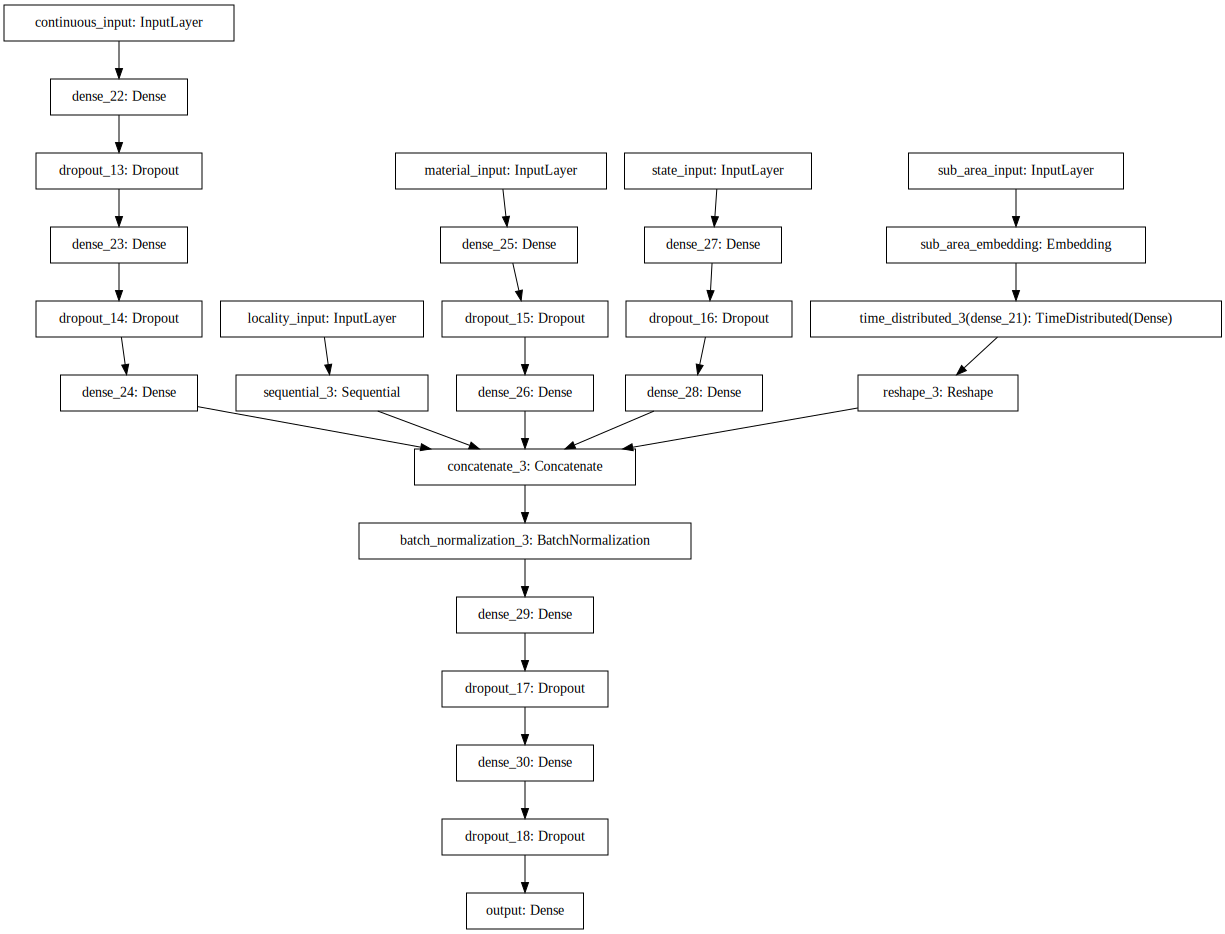

In [101]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
SVG(model_to_dot(house_price_model).create(prog='dot', format='svg'))

In [102]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
    y_pred_log = K.log(y_pred + 1.)
    y_true_log = K.log(y_true + 1.)
    return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

In [103]:
house_price_model.compile(optimizer = "adam", loss = root_mean_squared_logarithmic_error)

### Train the model

In [107]:
epochs = 100
version = 0

In [108]:
checkpointer = ModelCheckpoint(filepath="/mnt/h/Kaggle/Competitions/Russian Bank/models/v" + str(version) + "/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="/mnt/h/Kaggle/Competitions/Russian Bank/models/v" + str(version) + "/logs/",
                          histogram_freq=0, 
                          write_graph=True, 
                         # write_grads=True, 
                          write_images=False, 
                          embeddings_freq=10, 
                          embeddings_layer_names=[
                              'sub_area_embedding'
                          ], embeddings_metadata={
                              'sub_area_embedding':'/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv'
                          })
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='auto')
callbacks = [checkpointer, tensorboard, early_stopping]

In [109]:
house_price_model.fit(x={'locality_input': np.concatenate((train_split_df_locality_features, val_split_df_locality_features), axis=0), 
                       'continuous_input': np.concatenate((train_split_df_continuous_features, val_split_df_continuous_features), axis=0),
                       'state_input' : np.concatenate((train_split_df_categorical_features['state_refractored'], val_split_df_categorical_features['state_refractored']), axis=0),
                       'material_input' : np.concatenate((train_split_df_categorical_features['material'], val_split_df_categorical_features['material']), axis=0),
                       'sub_area_input' : np.concatenate((train_split_df_categorical_features['sub_area'], val_split_df_categorical_features['sub_area']), axis=0)
                      },
                      y = np.concatenate((train_split_df['price_doc'].values, val_split_df['price_doc'].values), 0),
                      callbacks=callbacks,
                      verbose = 2,
                      validation_split=0.20,
                      shuffle=True,
                      epochs=epochs)

Train on 19500 samples, validate on 4876 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 4.65488, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v0/weights.00-4.65.hdf5
42s - loss: 7.2849 - val_loss: 4.6549
Epoch 2/100
Epoch 00001: val_loss improved from 4.65488 to 2.66864, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v0/weights.01-2.67.hdf5
15s - loss: 3.6077 - val_loss: 2.6686
Epoch 3/100
Epoch 00002: val_loss improved from 2.66864 to 1.45690, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v0/weights.02-1.46.hdf5
16s - loss: 2.0435 - val_loss: 1.4569
Epoch 4/100
Epoch 00003: val_loss improved from 1.45690 to 0.70688, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v0/weights.03-0.71.hdf5
18s - loss: 1.0529 - val_loss: 0.7069
Epoch 5/100
Epoch 00004: val_loss improved from 0.70688 to 0.37053, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v0/weights.04-0.37.hdf5
17s - loss: 0.5227 - val_los

KeyboardInterrupt: 

In [110]:
house_price_model.load_weights('/mnt/h/Kaggle/Competitions/Russian Bank/models/v0/weights.11-0.26.hdf5')

In [113]:
test_split_df[:10]

,full_sq,kitch_sq,floor,life_sq,build_year,railroad_km,metro_min_avto,green_zone_km,kindergarten_km,num_room,...,green_part_1000_scaled_feature,church_synagogue_km_scaled_feature,big_church_km_scaled_feature,green_part_1500_scaled_feature,incineration_km_scaled_feature,industrial_km_scaled_feature,nuclear_reactor_km_scaled_feature,material_scaled_feature,state_refractored_scaled_feature,sub_area_scaled_feature
9834,37,7.0,6.0,19.0,2005.0,1.957592,1.614250,0.820522,0.128803,1.0,...,-0.999843,1.425651,-0.094035,-0.651228,-1.189135,-0.116983,0.565621,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",45
14575,33,9.0,7.0,17.0,1969.0,0.537434,1.150791,0.077744,0.063817,1.0,...,-0.525153,-1.040911,-0.614657,-0.951932,0.508119,0.387158,-1.064232,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",29
15018,40,0.0,11.0,0.0,0.0,1.686871,2.596394,0.214336,1.170413,1.0,...,1.217904,0.469289,-0.335492,1.238203,1.272490,-0.907235,0.938649,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",103
1215,37,0.0,11.0,16.0,0.0,1.855308,2.177926,0.065910,0.291386,0.0,...,-0.940593,-0.075855,0.135646,-0.849819,0.326067,2.086563,-0.894526,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",109
7636,43,0.0,8.0,0.0,0.0,1.632706,3.253826,0.354124,0.128175,0.0,...,0.671562,-0.434085,-0.567126,0.440318,-0.874026,0.435830,-1.077061,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",80
6092,116,0.0,13.0,70.0,0.0,1.106429,10.744654,0.000000,0.089663,0.0,...,-0.020149,0.945246,-0.043772,-0.455454,0.297044,0.547003,-0.405206,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",51
19319,34,7.0,5.0,17.0,1955.0,0.637758,1.370650,0.161826,0.455536,1.0,...,-0.648476,1.144598,-0.168376,-1.085030,0.158253,-0.391341,-0.304718,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",129
23284,31,5.0,5.0,21.0,1967.0,0.037588,1.611313,0.108827,0.126053,2.0,...,-0.929570,-1.035338,-0.682632,-1.088551,0.127561,-0.402791,-0.294378,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",6
29822,53,1.0,3.0,0.0,0.0,0.663572,32.400256,0.556235,23.526686,2.0,...,1.634033,9.691475,6.463573,3.367774,5.167325,7.161745,4.961127,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",96
10903,32,6.0,7.0,19.0,1969.0,0.210546,5.017302,0.497769,0.191126,1.0,...,-0.739418,1.175750,-0.131558,-1.049819,-1.370275,-0.777619,-0.978441,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3


In [116]:
test_locality, test_continuous, test_cat = format_input(test_split_df[:10])
test_preds = house_price_model.predict({'locality_input': test_locality, 
                       'continuous_input': test_continuous,
                       'state_input' : test_cat['state_refractored'],
                       'material_input' : test_cat['material'],
                       'sub_area_input' : test_cat['sub_area']
                      })
test_actuals = test_split_df[:10].price_doc.values

In [122]:
zip(test_actuals, test_preds.ravel())

[(5200000, 5537588.0),
 (9500000, 11733996.0),
 (4317880, 5418635.0),
 (1000000, 7600478.0),
 (3984584, 5914595.0),
 (15500000, 13758412.0),
 (5600000, 4990829.0),
 (8500000, 8578904.0),
 (3175380, 3498355.5),
 (4850000, 5653930.0)]

In [125]:
test_locality, test_continuous, test_cat = format_input(test_split_df)
test_eval = house_price_model.evaluate(x={'locality_input': test_locality, 
                       'continuous_input': test_continuous,
                       'state_input' : test_cat['state_refractored'],
                       'material_input' : test_cat['material'],
                       'sub_area_input' : test_cat['sub_area']
                      },
                      y = test_split_df.price_doc.values,
                                      verbose = 0)
test_actuals = test_split_df.price_doc.values

6095/6095 [==============================] - 3s      

In [126]:
test_eval # WOW! AMAZING!!! An error of 0.2646

0.26461586624114997

In [143]:
kaggle_test = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/test.csv/test.csv")

In [144]:
kaggle_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [145]:
macro_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/macro.csv/macro.csv")

In [146]:
final_kaggle_df = pd.merge(kaggle_test, macro_df, on='timestamp')

In [147]:
final_kaggle_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9


In [148]:
final_kaggle_df = prepare_dataset(final_kaggle_df)

In [149]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_kaggle_df[[continuous_norm_col]].values)
    final_kaggle_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [150]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_kaggle_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_kaggle_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

In [153]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_kaggle_df[[label_col]].values)
    final_kaggle_df[label_col + "_scaled_feature"] = encoded_values

In [154]:
[c for c in final_kaggle_df.columns.tolist() if "_scaled_feature" in c]

['full_sq_scaled_feature',
 'kitch_sq_scaled_feature',
 'floor_scaled_feature',
 'life_sq_scaled_feature',
 'build_year_scaled_feature',
 'railroad_km_scaled_feature',
 'metro_min_avto_scaled_feature',
 'green_zone_km_scaled_feature',
 'kindergarten_km_scaled_feature',
 'num_room_scaled_feature',
 'public_transport_station_km_scaled_feature',
 'metro_km_avto_scaled_feature',
 'max_floor_scaled_feature',
 'micex_scaled_feature',
 'usdrub_scaled_feature',
 'park_km_scaled_feature',
 'micex_cbi_tr_scaled_feature',
 'timestamp_day_scaled_feature',
 'timestamp_month_scaled_feature',
 'timestamp_year_scaled_feature',
 'cemetery_km_scaled_feature',
 'mosque_km_scaled_feature',
 'public_healthcare_km_scaled_feature',
 'catering_km_scaled_feature',
 'big_road2_km_scaled_feature',
 'hospice_morgue_km_scaled_feature',
 'swim_pool_km_scaled_feature',
 'water_treatment_km_scaled_feature',
 'power_transmission_line_km_scaled_feature',
 'water_km_scaled_feature',
 'school_km_scaled_feature',
 'ttk_km

In [155]:
kaggle_locality, kaggle_continuous, kaggle_cat = format_input(final_kaggle_df)
kaggle_preds = house_price_model.predict({'locality_input': kaggle_locality, 
                       'continuous_input': kaggle_continuous,
                       'state_input' : kaggle_cat['state_refractored'],
                       'material_input' : kaggle_cat['material'],
                       'sub_area_input' : kaggle_cat['sub_area']
                      })

In [160]:
final_kaggle_df['price_doc'] = kaggle_preds

In [161]:
final_kaggle_df['price_doc']

0        6654852.50
1        8137595.50
2        6643443.00
3        7558576.00
4        6021214.50
5        9761289.00
6        5222332.00
7        4738903.00
8        6210076.50
9        5893429.00
10       6833310.00
11       5909655.50
12       5441475.50
13       5358815.50
14       5392649.00
15       6625846.50
16      10857244.00
17      11826922.00
18       6834672.00
19      11518202.00
20       7825843.50
21      10500059.00
22       8354817.50
23       8536329.00
24       5420567.00
25       9973714.00
26      10584601.00
27       8417826.00
28       3887790.75
29       7488494.00
           ...     
7632     6934862.00
7633     4155310.75
7634    11951322.00
7635     6548668.00
7636     3756825.00
7637     5837263.50
7638     4721193.00
7639     7713059.00
7640     7179763.50
7641     4699787.00
7642     8086678.00
7643     7411773.00
7644     8673637.00
7645     5052364.00
7646     8423050.00
7647     7729265.00
7648     8618761.00
7649     6426324.50
7650     7680965.00


In [162]:
final_kaggle_df[['id', 'price_doc']]

,id,price_doc
0,30474,6654852.50
1,30475,8137595.50
2,30476,6643443.00
3,30477,7558576.00
4,30478,6021214.50
5,30479,9761289.00
6,30480,5222332.00
7,30481,4738903.00
8,30482,6210076.50
9,30483,5893429.00


In [164]:
final_kaggle_df[['id', 'price_doc']].to_csv("/mnt/h/Kaggle/Competitions/Russian Bank/models/v0/submission.csv", index=False) # output submission csv file